# Limpieza y Preprocesamiento de Datos Financieros

Este notebook muestra paso a paso cómo funciona el módulo de limpieza de datos financieros.

**Objetivo**: Entender qué problemas existen en los datos crudos y cómo el `DataCleaner` los soluciona.

In [1]:
import sys
from pathlib import Path

# Añadir src al path
project_root = Path().resolve().parent
sys.path.insert(0, str(project_root))

from src.data import DataProvider
from src.data.cleaning import DataCleaner, CleaningMetadata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

print("Módulos importados correctamente")

Módulos importados correctamente


## 1. Carga de Datos "Sucios"

Primero, cargamos datos desde el DataProvider. Estos datos pueden tener problemas comunes:
- Valores nulos
- Duplicados
- Relaciones OHLC inválidas
- Outliers
- Problemas de formato

In [2]:
# Inicializar proveedor de datos
provider = DataProvider()

# Obtener datos de precios
symbol = "AAPL"
raw_price_data = provider.get_price_data(symbol, period="1y", interval="1d")

print(f"Datos obtenidos para {symbol}")
print(f"Shape: {raw_price_data.shape}")
print(f"\nPrimeras filas:")
display(raw_price_data.head())
print(f"\nÚltimas filas:")
display(raw_price_data.tail())

INFO:src.data.raw.data_yahoo_finance:Datos cargados desde cache: AAPL_price_1y_1d.pkl


Datos obtenidos para AAPL
Shape: (251, 7)

Primeras filas:


,Open,High,Low,Close,Volume,Dividends,Stock splits
Date,,,,,,,
2025-01-14 00:00:00-05:00,233.693058,235.056885,231.423325,232.229675,39435300,0.0,0.0
2025-01-15 00:00:00-05:00,233.583543,237.884100,233.374482,236.798996,39832000,0.0,0.0
2025-01-16 00:00:00-05:00,236.281370,236.938386,227.003324,227.232285,71759100,0.0,0.0
2025-01-17 00:00:00-05:00,231.074899,231.244131,227.451288,228.944534,68488300,0.0,0.0
2025-01-21 00:00:00-05:00,222.991466,223.409573,218.392272,221.637589,98070400,0.0,0.0



Últimas filas:


,Open,High,Low,Close,Volume,Dividends,Stock splits
Date,,,,,,,
2026-01-07 00:00:00-05:00,263.200012,263.679993,259.809998,260.329987,48309800,0.0,0.0
2026-01-08 00:00:00-05:00,257.019989,259.290009,255.699997,259.040009,50419300,0.0,0.0
2026-01-09 00:00:00-05:00,259.079987,260.209991,256.220001,259.369995,39997000,0.0,0.0
2026-01-12 00:00:00-05:00,259.160004,261.299988,256.799988,260.250000,45263800,0.0,0.0
2026-01-13 00:00:00-05:00,258.720001,261.809998,258.390015,261.049988,45697500,0.0,0.0


## 2. Análisis Inicial de los Datos

Antes de limpiar, analicemos qué problemas tienen los datos.

In [10]:
# Análisis de datos faltantes
print("=== ANÁLISIS DE VALORES FALTANTES ===")
missing = raw_price_data.isnull().sum()
missing_pct = (missing / len(raw_price_data)) * 100
missing_df = pd.DataFrame({
    'Valores Faltantes': missing,
    'Porcentaje': missing_pct
})
display(missing_df[missing_df['Valores Faltantes'] > 0])

# Análisis de duplicados
print(f"\n=== DUPLICADOS ===")
duplicates = raw_price_data.index.duplicated().sum()
print(f"Filas duplicadas: {duplicates}")

# Información general
print(f"\n=== INFORMACIÓN GENERAL ===")
print(f"Rango de fechas: {raw_price_data.index.min()} a {raw_price_data.index.max()}")
print(f"Total de días: {len(raw_price_data)}")
print(f"\nTipos de datos:")
print(raw_price_data.dtypes)

=== ANÁLISIS DE VALORES FALTANTES ===


,Valores Faltantes,Porcentaje



=== DUPLICADOS ===
Filas duplicadas: 0

=== INFORMACIÓN GENERAL ===
Rango de fechas: 2025-01-14 00:00:00-05:00 a 2026-01-13 00:00:00-05:00
Total de días: 251

Tipos de datos:
Open            float64
High            float64
Low             float64
Close           float64
Volume            int64
Dividends       float64
Stock splits    float64
dtype: object


## 3. Visualización de Datos Antes de la Limpieza

Veamos cómo se ven los datos antes de limpiarlos.

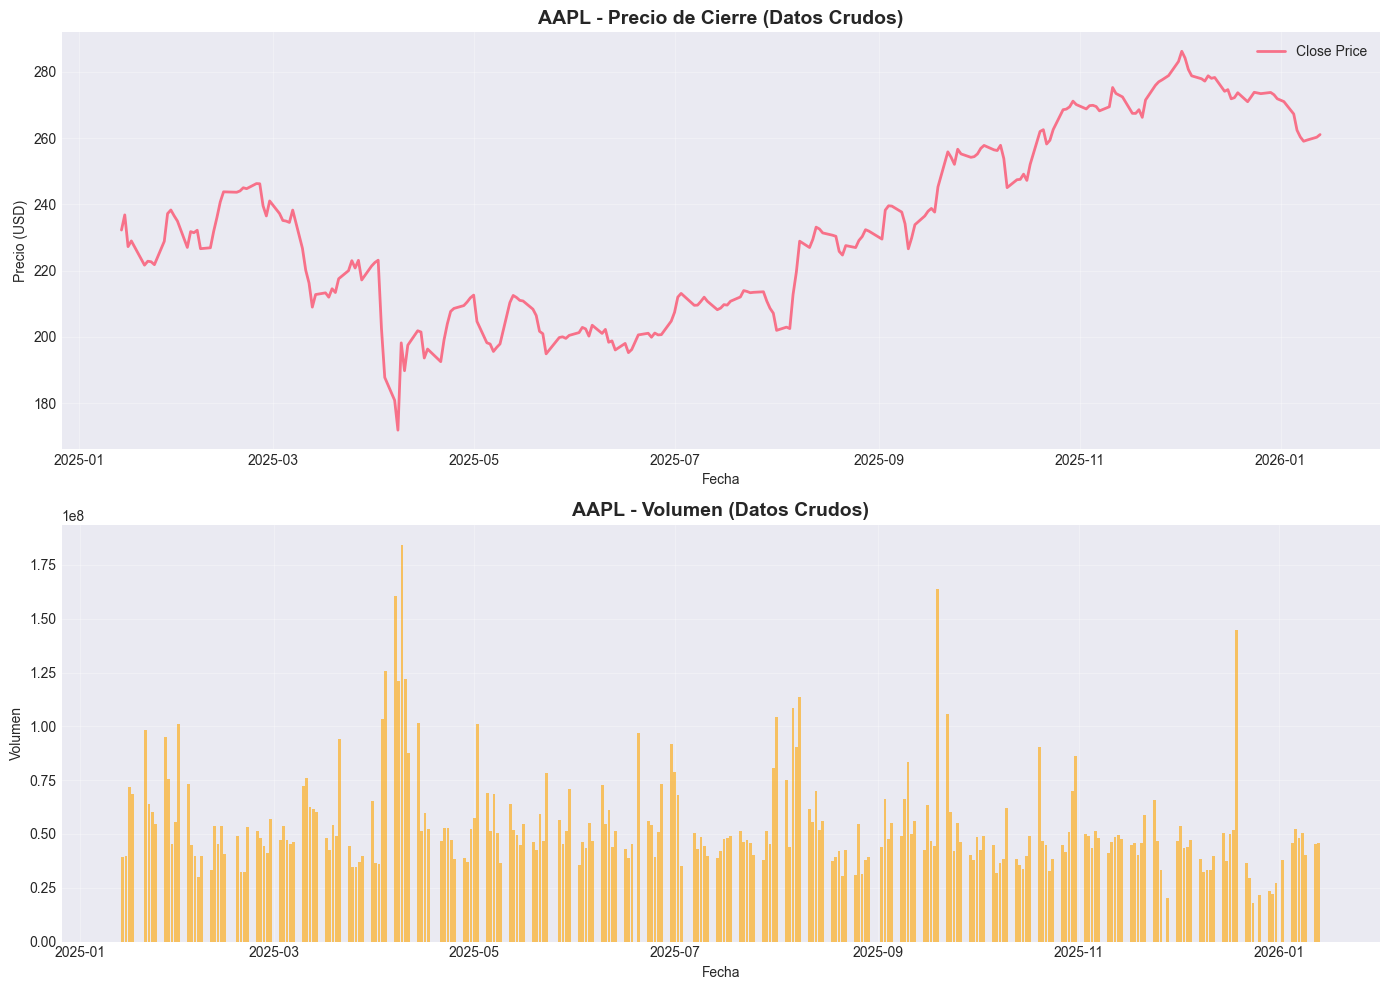


=== ESTADÍSTICAS DESCRIPTIVAS (Datos Crudos) ===


,Open,High,Low,Close,Volume,Dividends,Stock splits
count,251.000000,251.000000,251.000000,251.000000,2.510000e+02,251.000000,251.0
mean,232.334819,235.032527,229.933343,232.529206,5.409806e+07,0.004104,0.0
std,27.182995,26.857773,27.314535,27.092781,2.332593e+07,0.032316,0.0
min,171.364011,189.691359,168.633375,171.832428,1.791060e+07,0.000000,0.0
25%,209.573763,211.600513,207.471736,209.573761,4.102490e+07,0.000000,0.0
50%,229.757264,232.194911,227.003324,229.807220,4.754940e+07,0.000000,0.0
75%,255.956877,258.099794,254.293481,256.531311,5.656095e+07,0.000000,0.0
max,286.200012,288.619995,283.299988,286.190002,1.843959e+08,0.260000,0.0


In [11]:
# Gráfico de precios antes de limpiar
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Precio de cierre
axes[0].plot(raw_price_data.index, raw_price_data['Close'], label='Close Price', linewidth=2)
axes[0].set_title(f'{symbol} - Precio de Cierre (Datos Crudos)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Fecha')
axes[0].set_ylabel('Precio (USD)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Volumen
axes[1].bar(raw_price_data.index, raw_price_data['Volume'], alpha=0.6, color='orange')
axes[1].set_title(f'{symbol} - Volumen (Datos Crudos)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Fecha')
axes[1].set_ylabel('Volumen')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Estadísticas descriptivas
print("\n=== ESTADÍSTICAS DESCRIPTIVAS (Datos Crudos) ===")
display(raw_price_data.describe())

## 4. Aplicación del DataCleaner

Ahora aplicamos el DataCleaner para limpiar los datos. Veamos qué hace paso a paso.

In [12]:
# Crear instancia del limpiador
cleaner = DataCleaner(
    fill_method='forward',      # Forward-fill para valores nulos
    remove_outliers=False,      # No eliminar outliers automáticamente (solo detectar)
    validate_ohlc=True,         # Validar relaciones OHLC
    normalize_column_names=True # Normalizar nombres de columnas
)

# Limpiar datos
cleaned_price_data, metadata = cleaner.clean_price_data(raw_price_data, symbol=symbol)

print("=== LIMPIEZA COMPLETADA ===\n")
print(metadata.summary())

INFO:src.data.cleaning.data_cleaner:Limpiando datos de precios para AAPL...
INFO:src.data.cleaning.data_cleaner:Limpieza completada. Filas: 251 -> 251


=== LIMPIEZA COMPLETADA ===

Forma original: (251, 7)
Forma final: (251, 12)
Filas eliminadas: 0
Columnas eliminadas: 0
Valores nulos imputados: 0
Valores nulos eliminados: 0
Duplicados eliminados: 0
Outliers detectados: 0
Filas OHLC inválidas: 0

Transformaciones aplicadas:
  - Normalización de nombres de columnas
  - Ordenamiento por fecha
  - Forward-fill de valores nulos
  - Adición de columnas auxiliares (returns, log_returns, etc.)
  - Normalización de zona horaria


## 5. Comparación Antes vs Después

Comparemos los datos antes y después de la limpieza.

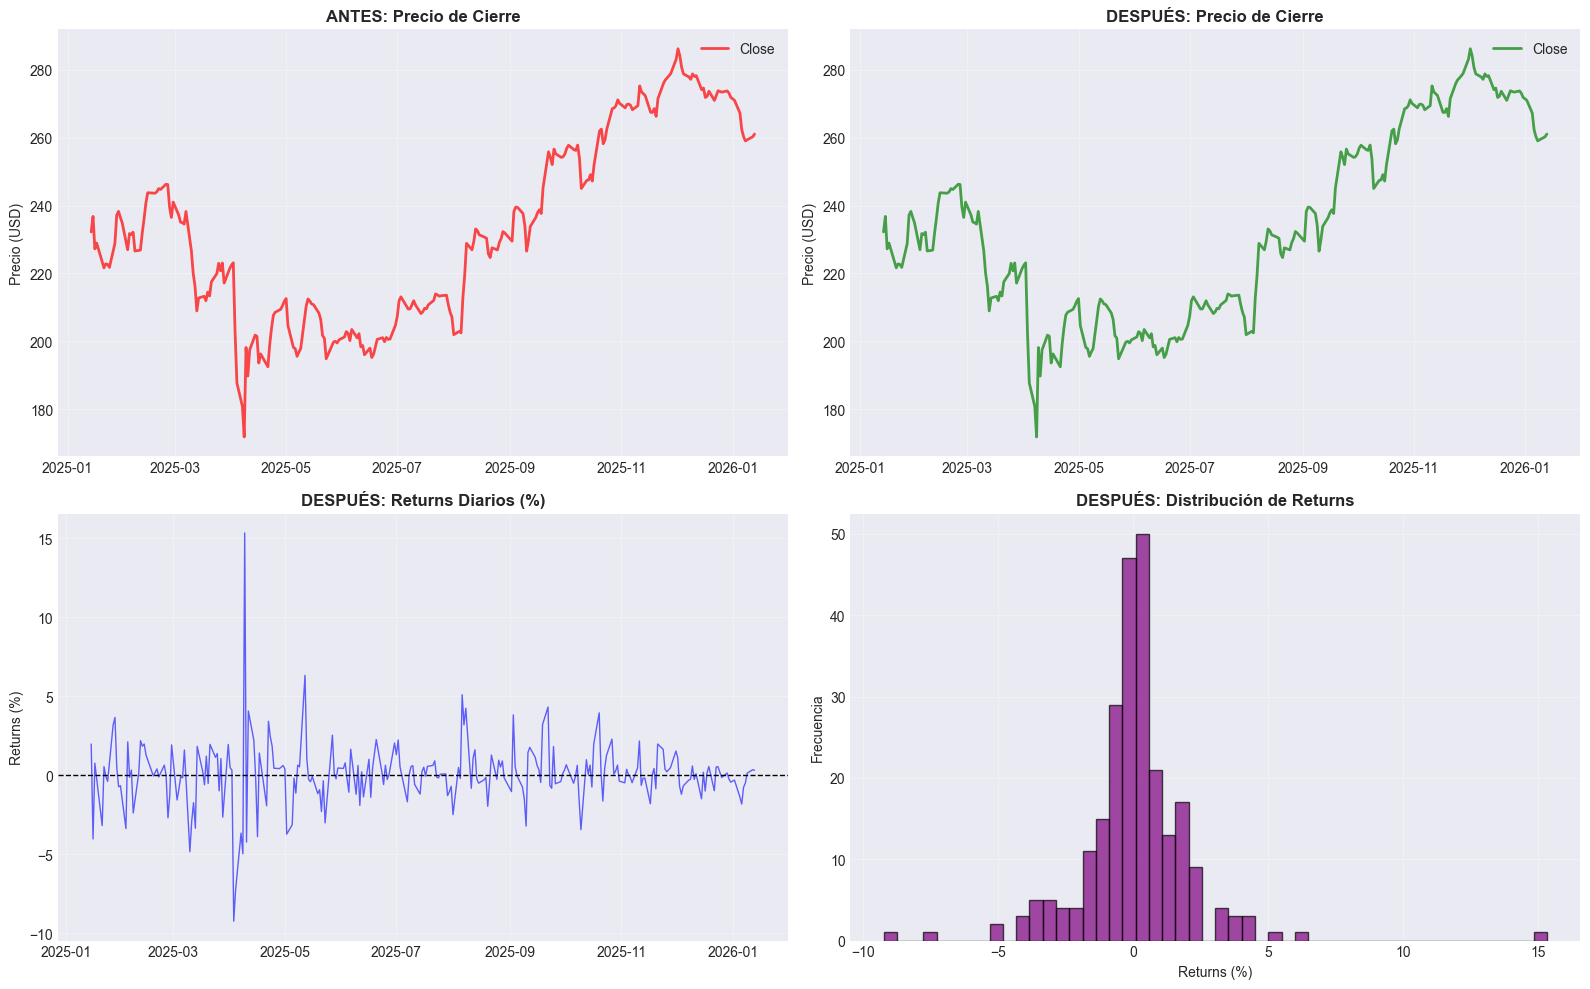


=== COMPARACIÓN DE ESTADÍSTICAS ===


,Antes (Close),Después (close)
count,251.000000,251.000000
mean,232.529206,232.529206
std,27.092781,27.092781
min,171.832428,171.832428
25%,209.573761,209.573761
50%,229.807220,229.807220
75%,256.531311,256.531311
max,286.190002,286.190002


In [13]:
# Comparación visual
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Precio de cierre - Antes
axes[0, 0].plot(raw_price_data.index, raw_price_data['Close'], label='Close', linewidth=2, color='red', alpha=0.7)
axes[0, 0].set_title('ANTES: Precio de Cierre', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Precio (USD)')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Precio de cierre - Después
axes[0, 1].plot(cleaned_price_data.index, cleaned_price_data['close'], label='Close', linewidth=2, color='green', alpha=0.7)
axes[0, 1].set_title('DESPUÉS: Precio de Cierre', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('Precio (USD)')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Returns - Solo después (no existen antes)
if 'returns' in cleaned_price_data.columns:
    axes[1, 0].plot(cleaned_price_data.index, cleaned_price_data['returns'] * 100, linewidth=1, color='blue', alpha=0.6)
    axes[1, 0].set_title('DESPUÉS: Returns Diarios (%)', fontsize=12, fontweight='bold')
    axes[1, 0].set_ylabel('Returns (%)')
    axes[1, 0].axhline(y=0, color='black', linestyle='--', linewidth=1)
    axes[1, 0].grid(True, alpha=0.3)

# Distribución de returns
if 'returns' in cleaned_price_data.columns:
    axes[1, 1].hist(cleaned_price_data['returns'].dropna() * 100, bins=50, alpha=0.7, color='purple', edgecolor='black')
    axes[1, 1].set_title('DESPUÉS: Distribución de Returns', fontsize=12, fontweight='bold')
    axes[1, 1].set_xlabel('Returns (%)')
    axes[1, 1].set_ylabel('Frecuencia')
    axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Tabla comparativa
print("\n=== COMPARACIÓN DE ESTADÍSTICAS ===")
comparison = pd.DataFrame({
    'Antes (Close)': raw_price_data['Close'].describe(),
    'Después (close)': cleaned_price_data['close'].describe()
})
display(comparison)

## 6. Columnas Añadidas por el Limpiador

El DataCleaner añade columnas útiles para análisis.

In [7]:
print("=== COLUMNAS ORIGINALES ===")
print(list(raw_price_data.columns))

print("\n=== COLUMNAS DESPUÉS DE LA LIMPIEZA ===")
print(list(cleaned_price_data.columns))

print("\n=== NUEVAS COLUMNAS AÑADIDAS ===")
new_columns = set(cleaned_price_data.columns) - set([col.lower() for col in raw_price_data.columns])
print(list(new_columns))

if new_columns:
    print("\n=== MUESTRA DE NUEVAS COLUMNAS ===")
    display(cleaned_price_data[list(new_columns)].head(10))

=== COLUMNAS ORIGINALES ===
['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock splits']

=== COLUMNAS DESPUÉS DE LA LIMPIEZA ===
['open', 'high', 'low', 'close', 'volume', 'dividends', 'stock splits', 'returns', 'log_returns', 'price_change', 'pct_change', 'volatility_20']

=== NUEVAS COLUMNAS AÑADIDAS ===
['pct_change', 'price_change', 'log_returns', 'returns', 'volatility_20']

=== MUESTRA DE NUEVAS COLUMNAS ===


,pct_change,price_change,log_returns,returns,volatility_20
Date,,,,,
2025-01-14,NaN,NaN,NaN,NaN,NaN
2025-01-15,1.967587,4.569321,0.019485,0.019676,NaN
2025-01-16,-4.040014,-9.566711,-0.041239,-0.040400,NaN
2025-01-17,0.753524,1.712250,0.007507,0.007535,NaN
2025-01-21,-3.191579,-7.306946,-0.032436,-0.031916,NaN
2025-01-22,0.534490,1.184631,0.005331,0.005345,NaN
2025-01-23,-0.075944,-0.169220,-0.000760,-0.000759,NaN
2025-01-24,-0.393454,-0.876038,-0.003942,-0.003935,NaN
2025-01-27,3.178025,7.048126,0.031286,0.031780,NaN


In [8]:
# Obtener datos fundamentales
raw_fundamental = provider.get_fundamental_data(symbol)

print("=== DATOS FUNDAMENTALES CRUDOS (Primeros 10) ===")
fundamental_df = pd.DataFrame(list(raw_fundamental.items())[:10], columns=['Métrica', 'Valor'])
display(fundamental_df)

# Limpiar datos fundamentales
cleaned_fundamental, fundamental_metadata = cleaner.clean_fundamental_data(raw_fundamental)

print("\n=== METADATA DE LIMPIEZA ===")
print(fundamental_metadata.summary())

print("\n=== DATOS FUNDAMENTALES LIMPIOS (Primeros 10) ===")
cleaned_fundamental_df = pd.DataFrame(list(cleaned_fundamental.items())[:10], columns=['Métrica', 'Valor'])
display(cleaned_fundamental_df)

INFO:src.data.raw.data_yahoo_finance:Datos cargados desde cache: AAPL_fundamental.pkl


=== DATOS FUNDAMENTALES CRUDOS (Primeros 10) ===


,Métrica,Valor
0,symbol,AAPL
1,name,Apple Inc.
2,sector,Technology
3,industry,Consumer Electronics
4,market_cap,3857366646784
5,enterprise_value,3915046977536
6,pe_ratio,34.946453
7,forward_pe,28.526094
8,peg_ratio,None
9,price_to_book,52.304142


INFO:src.data.cleaning.data_cleaner:Limpiando datos fundamentales...
INFO:src.data.cleaning.data_cleaner:Limpieza de datos fundamentales completada



=== METADATA DE LIMPIEZA ===
Forma original: (0, 0)
Forma final: (0, 0)
Filas eliminadas: 0
Columnas eliminadas: 0
Valores nulos imputados: 1
Valores nulos eliminados: 0
Duplicados eliminados: 0
Outliers detectados: 0
Filas OHLC inválidas: 0

Transformaciones aplicadas:
  - Normalización de datos fundamentales
  - Validación de ratios básicos

=== DATOS FUNDAMENTALES LIMPIOS (Primeros 10) ===


,Métrica,Valor
0,symbol,AAPL
1,name,Apple Inc.
2,sector,Technology
3,industry,Consumer Electronics
4,market_cap,3857366646784.0
5,enterprise_value,3915046977536.0
6,pe_ratio,34.946453
7,forward_pe,28.526094
8,peg_ratio,None
9,price_to_book,52.304142


## 7. Limpieza de Estados Financieros

Finalmente, veamos cómo se limpian los estados financieros.

In [9]:
# Obtener estados financieros
raw_income = provider.get_financial_statements(symbol, "income")

print("=== INCOME STATEMENT CRUDO (Primeras 10 filas) ===")
display(raw_income.head(10))

# Limpiar income statement
cleaned_income, income_metadata = cleaner.clean_financial_statement(raw_income, "income")

print("\n=== METADATA DE LIMPIEZA ===")
print(income_metadata.summary())

print("\n=== INCOME STATEMENT LIMPIO (Primeras 10 filas) ===")
display(cleaned_income.head(10))

INFO:src.data.raw.data_yahoo_finance:Datos cargados desde cache: AAPL_statement_income.pkl


=== INCOME STATEMENT CRUDO (Primeras 10 filas) ===


,2025-09-30,2024-09-30,2023-09-30,2022-09-30,2021-09-30
Tax Effect Of Unusual Items,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN
Tax Rate For Calcs,1.560000e-01,2.410000e-01,1.470000e-01,1.620000e-01,NaN
Normalized EBITDA,1.447480e+11,1.346610e+11,1.258200e+11,1.305410e+11,NaN
Net Income From Continuing Operation Net Minority Interest,1.120100e+11,9.373600e+10,9.699500e+10,9.980300e+10,NaN
Reconciled Depreciation,1.169800e+10,1.144500e+10,1.151900e+10,1.110400e+10,NaN
Reconciled Cost Of Revenue,2.209600e+11,2.103520e+11,2.141370e+11,2.235460e+11,NaN
EBITDA,1.447480e+11,1.346610e+11,1.258200e+11,1.305410e+11,NaN
EBIT,1.330500e+11,1.232160e+11,1.143010e+11,1.194370e+11,NaN
Net Interest Income,NaN,NaN,-1.830000e+08,-1.060000e+08,1.980000e+08
Interest Expense,NaN,NaN,3.933000e+09,2.931000e+09,2.645000e+09


INFO:src.data.cleaning.data_cleaner:Limpiando income statement...
INFO:src.data.cleaning.data_cleaner:Limpieza de income statement completada



=== METADATA DE LIMPIEZA ===
Forma original: (39, 5)
Forma final: (38, 5)
Filas eliminadas: 1
Columnas eliminadas: 0
Valores nulos imputados: 45
Valores nulos eliminados: 0
Duplicados eliminados: 0
Outliers detectados: 0
Filas OHLC inválidas: 0

Transformaciones aplicadas:
  - Ordenamiento cronológico de columnas
  - Reemplazo de valores nulos con 0
  - Eliminación de 1 filas vacías

=== INCOME STATEMENT LIMPIO (Primeras 10 filas) ===


,2025-09-30,2024-09-30,2023-09-30,2022-09-30,2021-09-30
Tax Rate For Calcs,1.560000e-01,2.410000e-01,1.470000e-01,1.620000e-01,0.000000e+00
Normalized EBITDA,1.447480e+11,1.346610e+11,1.258200e+11,1.305410e+11,0.000000e+00
Net Income From Continuing Operation Net Minority Interest,1.120100e+11,9.373600e+10,9.699500e+10,9.980300e+10,0.000000e+00
Reconciled Depreciation,1.169800e+10,1.144500e+10,1.151900e+10,1.110400e+10,0.000000e+00
Reconciled Cost Of Revenue,2.209600e+11,2.103520e+11,2.141370e+11,2.235460e+11,0.000000e+00
EBITDA,1.447480e+11,1.346610e+11,1.258200e+11,1.305410e+11,0.000000e+00
EBIT,1.330500e+11,1.232160e+11,1.143010e+11,1.194370e+11,0.000000e+00
Net Interest Income,0.000000e+00,0.000000e+00,-1.830000e+08,-1.060000e+08,1.980000e+08
Interest Expense,0.000000e+00,0.000000e+00,3.933000e+09,2.931000e+09,2.645000e+09
Interest Income,0.000000e+00,0.000000e+00,3.750000e+09,2.825000e+09,2.843000e+09


## 8. Resumen y Lecciones Aprendidas

### ¿Qué problemas solucionó el DataCleaner?

1. **Normalización**: Nombres de columnas normalizados a minúsculas
2. **Ordenamiento**: Datos ordenados cronológicamente
3. **Duplicados**: Eliminación de filas duplicadas
4. **Validación OHLC**: Eliminación de relaciones inválidas (High < Low, etc.)
5. **Valores nulos**: Imputación inteligente según método elegido
6. **Tipos de datos**: Conversión a tipos numéricos correctos
7. **Columnas auxiliares**: Añadidas returns, log_returns, volatilidad, etc.
8. **Zona horaria**: Normalización de zonas horarias

### ¿Por qué es importante?

- **Análisis técnico**: Requiere datos limpios y consistentes
- **Backtesting**: Datos inválidos pueden causar resultados erróneos
- **Scoring**: Métricas calculadas sobre datos sucios son incorrectas
- **Visualización**: Gráficos más claros y precisos

### Próximos pasos

Los datos limpios están listos para:
- Análisis técnico (indicadores, estrategias)
- Análisis fundamental (ratios, métricas)
- Sistema de scoring
- Backtesting